# Autoencoder and Dimension Reduction (2/2)

# Application to actual financial data

## References: 
* https://medium.com/mlreview/a-simple-deep-learning-model-for-stock-price-prediction-using-tensorflow-30505541d877
* https://github.com/sebastianheinz/stockprediction

* Predicting S&P 500 index based on 500 constituents prices 1 minute ago
* 500 stock price from April to August 2017 and S&P 500 index level

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

This dataset is already preprocessed - any missing data is filled with last observation and the SP500 index level is shifted forward by 1 minute. Therefore, each row represents SP500 level at t+1 while constituent stock prices at t

In [2]:
stock_data = pd.read_csv('./01_data/data_stocks.csv')
stock_data = stock_data.drop(['DATE'], 1) # Date is of no use - not a time series analysis

In [3]:
stock_data.head()

,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,NASDAQ.AMAT,...,NYSE.WYN,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS
0,2363.6101,42.3300,143.6800,129.6300,82.040,102.2300,85.2200,59.760,121.52,38.99,...,84.370,119.035,44.40,39.88,82.03,7.36,50.22,63.86,122.000,53.350
1,2364.1001,42.3600,143.7000,130.3200,82.080,102.1400,85.6500,59.840,121.48,39.01,...,84.370,119.035,44.11,39.88,82.03,7.38,50.22,63.74,121.770,53.350
2,2362.6799,42.3100,143.6901,130.2250,82.030,102.2125,85.5100,59.795,121.93,38.91,...,84.585,119.260,44.09,39.98,82.02,7.36,50.12,63.75,121.700,53.365
3,2364.3101,42.3700,143.6400,130.0729,82.000,102.1400,85.4872,59.620,121.44,38.84,...,84.460,119.260,44.25,39.99,82.02,7.35,50.16,63.88,121.700,53.380
4,2364.8501,42.5378,143.6600,129.8800,82.035,102.0600,85.7001,59.620,121.60,38.93,...,84.470,119.610,44.11,39.96,82.03,7.36,50.20,63.91,121.695,53.240


In [11]:
stock_data.tail()

,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,NASDAQ.AMAT,...,NYSE.WYN,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS
41261,2472.22,44.72,164.11,155.090,83.67,106.565,114.49,47.150,142.425,45.130,...,99.675,99.53,49.485,40.955,76.360,32.285,62.110,76.88,114.31,62.7250
41262,2471.77,44.73,164.12,155.160,83.65,106.590,114.52,47.150,142.450,45.130,...,99.730,99.63,49.480,40.960,76.370,32.295,62.100,76.90,114.33,62.7100
41263,2470.03,44.74,164.01,155.065,83.62,106.520,114.47,47.150,142.330,45.135,...,99.735,99.64,49.495,40.940,76.315,32.290,62.090,76.88,114.31,62.6850
41264,2471.49,44.71,163.88,154.960,83.58,106.400,114.33,47.135,142.170,45.065,...,99.700,99.63,49.485,40.925,76.300,32.275,62.075,76.83,114.23,62.6301
41265,2471.49,44.74,163.98,155.160,83.69,106.470,114.46,47.150,142.410,45.120,...,99.670,99.64,49.490,40.940,76.320,32.270,62.070,76.81,114.28,62.6800


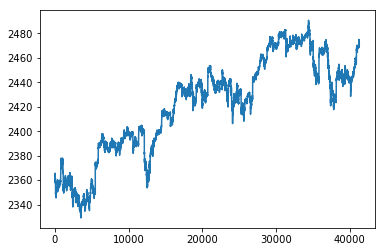

In [12]:
plt.plot(stock_data['SP500']);

In [13]:
n, p = stock_data.shape
stock_data = stock_data.values

In [14]:
# Split train vs dev set vs test set - 60% train 20% dev 20% test in chronological order
# Do not worry about cross validation here
data_train = stock_data[:int(0.6*n),:]
data_dev = stock_data[int(0.6*n):int(0.8*n), :]
data_test = stock_data[int(0.8*n):,:]

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
# Scale data
scaler = MinMaxScaler(feature_range=(-1,1))
data_train = scaler.fit_transform(data_train)
data_dev = scaler.transform(data_dev)
data_test = scaler.transform(data_test) # important not to fit test set. 

In [17]:
# Build X and Y
X_train = data_train[:, 1:]
y_train = data_train[:, 0]
X_dev = data_dev[:, 1:]
y_dev = data_dev[:, 0]
X_test = data_test[:, 1:]
y_test = data_test[:, 0]

In [18]:
print(X_train.shape)
print(y_train.shape)

(24759, 500)
(24759,)


In [20]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

In [45]:
tf.reset_default_graph() 
tf.set_random_seed(100)

In [46]:
# Define graph parameters
n_inputs = 500 # 500 stocks
n_hidden_1 = 256
n_hidden_2 = 128
n_hidden_3 = 128
n_hidden_4 = 64
n_output = 1 # output is the SP500 level - continuous function approximator

In [47]:
act_fn = tf.nn.relu # Define activation function. Reduce typing.. 

In [48]:
initializer = tf.variance_scaling_initializer(distribution='uniform')

In [49]:
# Layers
w1 = tf.Variable(initializer([n_inputs, n_hidden_1]), dtype=tf.float32)
w2 = tf.Variable(initializer([n_hidden_1, n_hidden_2]), dtype=tf.float32)
w3 = tf.Variable(initializer([n_hidden_2, n_hidden_3]), dtype=tf.float32)
w4 = tf.Variable(initializer([n_hidden_3, n_hidden_4]), dtype=tf.float32)
w_out = tf.Variable(initializer([n_hidden_4, n_output]), dtype=tf.float32)

# Biases
b1 = tf.Variable(tf.zeros(n_hidden_1))
b2 = tf.Variable(tf.zeros(n_hidden_2))
b3 = tf.Variable(tf.zeros(n_hidden_3))
b4 = tf.Variable(tf.zeros(n_hidden_4))
b_out = tf.Variable(tf.zeros(n_output))

In [50]:
# Construction
X = tf.placeholder(tf.float32, shape = [None, n_inputs]) # batch input
hidden_1 = act_fn(tf.matmul(X, w1) + b1)
hidden_2 = act_fn(tf.matmul(hidden_1, w2) + b2)
hidden_3 = act_fn(tf.matmul(hidden_2, w3) + b3)
hidden_4= act_fn(tf.matmul(hidden_3, w4) + b4)
output_layer = tf.transpose(tf.matmul(hidden_4, w_out) + b_out)

y_true = tf.placeholder(tf.float32, shape = [None]) # true answer

In [51]:
# Cost function
loss = tf.reduce_mean(tf.square(output_layer - y_true))

# Optimizer
optimizer = tf.train.AdamOptimizer() 
train = optimizer.minimize(loss)

In [52]:
init = tf.global_variables_initializer()

Loss train:  0.0022134478
Loss dev:  0.081266806
Loss train:  0.0003303439
Loss dev:  0.06049193
Loss train:  0.00022243058
Loss dev:  0.04895813
Loss train:  0.00015898838
Loss dev:  0.045318373
Loss train:  0.00016191544
Loss dev:  0.040756475
Loss train:  0.00013263505
Loss dev:  0.03817174
Loss train:  0.00013251204
Loss dev:  0.035889693
Loss train:  0.000108411215
Loss dev:  0.037608646
Loss train:  0.000117036405
Loss dev:  0.037698332
Loss train:  0.000108663146
Loss dev:  0.035580233


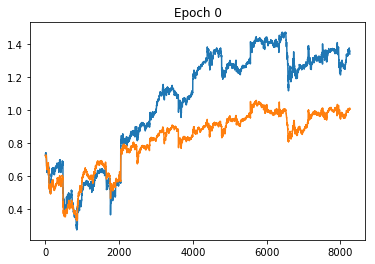

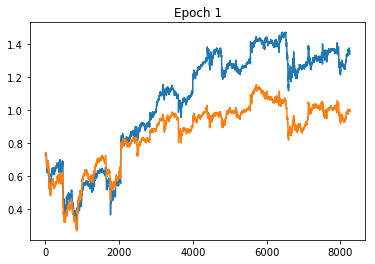

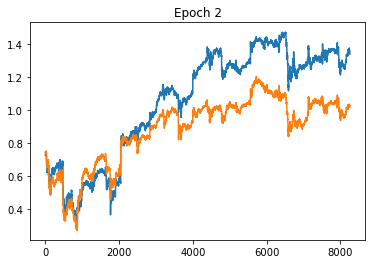

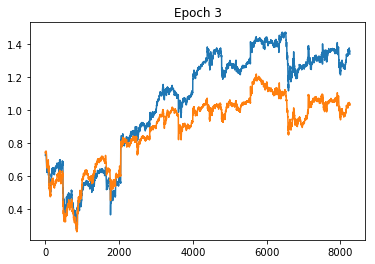

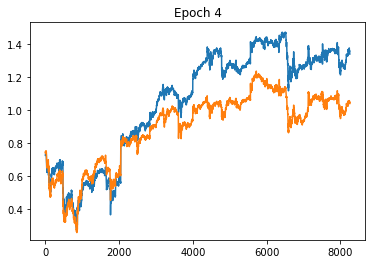

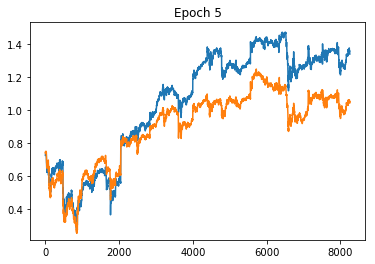

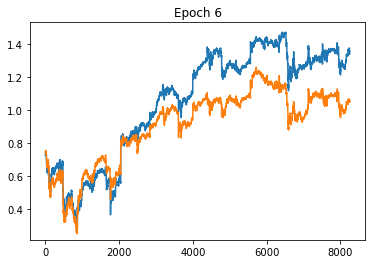

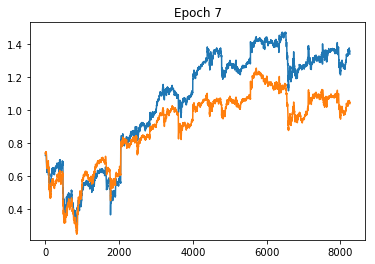

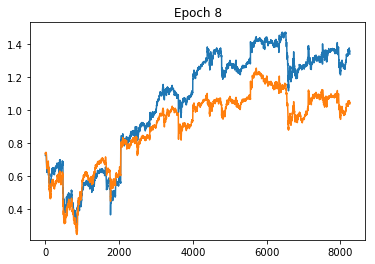

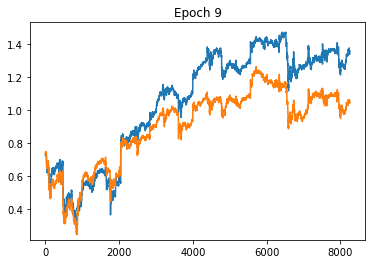

In [53]:
# actual train
num_epochs = 10
batch_size = 1024
loss_train = []
loss_dev = []

with tf.Session() as sess:
    sess.run(init)
    
    for e in range(num_epochs):
        
        # Shuffle training data for each epoch
        shuffle_indices = np.random.permutation(np.arange(len(y_train)))
        X_train_e = X_train[shuffle_indices]
        y_train_e = y_train[shuffle_indices]
        
        # Minibatch training
        num_batches = len(y_train) // batch_size
        for iteration in range(num_batches):
            start = iteration * batch_size
            x_batch = X_train_e[start:(start + batch_size)]
            y_batch = y_train_e[start:(start + batch_size)]
            sess.run(train, feed_dict={X: x_batch, y_true: y_batch})
            
        # Monitor training at each epoch
        loss_train.append(sess.run(loss, feed_dict={X: X_train, y_true: y_train}))
        loss_dev.append(sess.run(loss, feed_dict={X: X_dev, y_true: y_dev}))
        print('Loss train: ', loss_train[-1])
        print('Loss dev: ', loss_dev[-1])
        # Prediction
        pred = sess.run(output_layer, feed_dict={X: X_dev})

        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        line1, = ax1.plot(y_dev)
        line2, = ax1.plot(y_dev)
        line2.set_ydata(pred)
        plt.title('Epoch ' + str(e))
        plt.pause(0.01)
    
    # final report
    loss_test = sess.run(loss, feed_dict={X: X_test, y_true: y_test})

In [54]:
print(loss_dev)
print(loss_test)

[0.081266806, 0.06049193, 0.04895813, 0.045318373, 0.040756475, 0.03817174, 0.035889693, 0.037608646, 0.037698332, 0.035580233]
0.050177425


## Apply autoencoder and train

In [55]:
# Define autoencoder layers
n_auto = 100 # 1/5 reduction
auto_layer = fully_connected(X, n_auto, activation_fn=tf.nn.elu, 
                             weights_initializer=tf.variance_scaling_initializer, 
                             biases_initializer=tf.zeros_initializer)
auto_output = fully_connected(auto_layer, n_inputs, activation_fn=None,
                              weights_initializer=tf.variance_scaling_initializer, 
                              biases_initializer=tf.zeros_initializer)

loss_auto = tf.reduce_mean(tf.square(auto_output - X))
train_auto = tf.train.AdamOptimizer().minimize(loss_auto)

In [56]:
init = tf.global_variables_initializer()

In [57]:
# Auto encoder training
num_epochs = 200
num_batches = 1024

with tf.Session() as sess:
    sess.run(init)
    
    for e in range(num_epochs):

        # Shuffle training data for each epoch
        shuffle_indices = np.random.permutation(np.arange(len(y_train)))
        X_train_e = X_train[shuffle_indices]
        y_train_e = y_train[shuffle_indices]

        # Minibatch training
        num_batches = len(y_train) // batch_size
        for iteration in range(num_batches):
            start = iteration * batch_size
            x_batch = X_train_e[start:(start + batch_size)]
            sess.run(train_auto, feed_dict={X: x_batch})
        
        # see filtering results
        if e % 20 == 0: 
            loss_eval = sess.run(loss_auto, feed_dict={X: X_train})
            print('epoch {}: loss is {}'.format(e, loss_eval))
            
    # Later usage
    X_train_auto = auto_output.eval(feed_dict={X: X_train})
    X_dev_auto = auto_output.eval(feed_dict={X: X_dev})
    X_test_auto = auto_output.eval(feed_dict={X: X_test})

epoch 0: loss is 0.07607421278953552
epoch 20: loss is 0.004939901176840067
epoch 40: loss is 0.0027067656628787518
epoch 60: loss is 0.0018453176598995924
epoch 80: loss is 0.0014607991324737668
epoch 100: loss is 0.0011957020033150911
epoch 120: loss is 0.001055849832482636
epoch 140: loss is 0.0009573559509590268
epoch 160: loss is 0.0009453357197344303
epoch 180: loss is 0.0008138162083923817


Apply index prediction training

Loss train:  0.002135326
Loss dev:  0.027011124
Loss train:  0.00033832822
Loss dev:  0.015741097
Loss train:  0.0002186978
Loss dev:  0.012897207
Loss train:  0.00016709833
Loss dev:  0.011489184
Loss train:  0.00016260594
Loss dev:  0.010244909
Loss train:  0.00013084977
Loss dev:  0.0095101055
Loss train:  0.00014721618
Loss dev:  0.008692005
Loss train:  0.00015401118
Loss dev:  0.008326321
Loss train:  0.000113822025
Loss dev:  0.008263253
Loss train:  0.00010727906
Loss dev:  0.0076413923


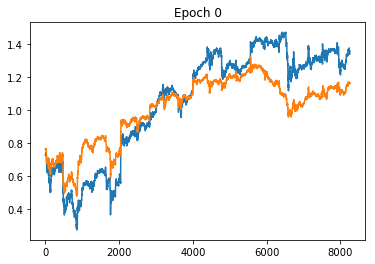

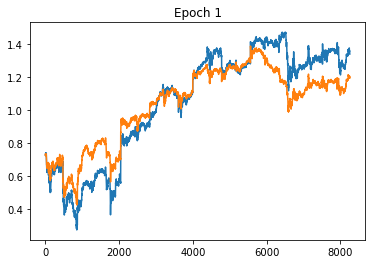

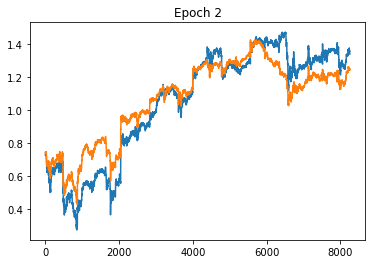

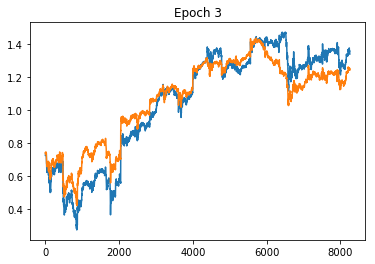

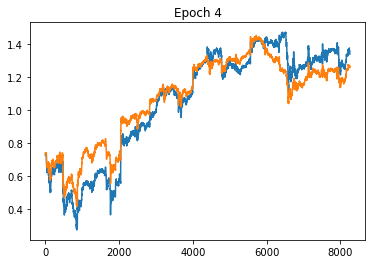

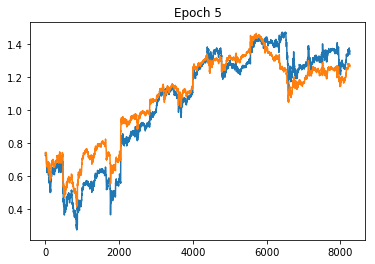

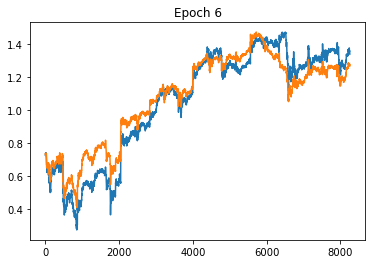

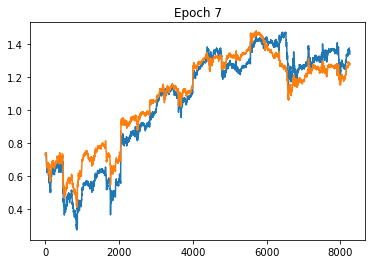

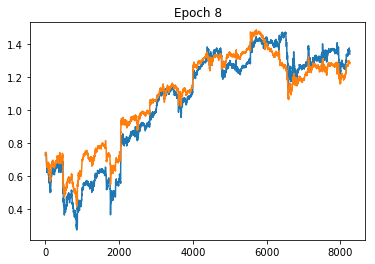

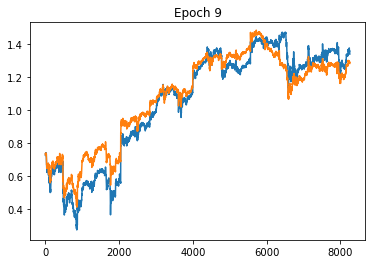

In [58]:
# actual train
num_epochs = 10
batch_size = 1024
loss_train_auto = []
loss_dev_auto = []

with tf.Session() as sess:
    sess.run(init)
    
    for e in range(num_epochs):
        
        # Shuffle training data for each epoch
        shuffle_indices = np.random.permutation(np.arange(len(y_train)))
        X_train_e = X_train_auto[shuffle_indices]
        y_train_e = y_train[shuffle_indices]
        
        # Minibatch training
        num_batches = len(y_train) // batch_size
        for iteration in range(num_batches):
            start = iteration * batch_size
            x_batch = X_train_e[start:(start + batch_size)]
            y_batch = y_train_e[start:(start + batch_size)]
            sess.run(train, feed_dict={X: x_batch, y_true: y_batch})
            
        # Monitor training at each epoch
        loss_train_auto.append(sess.run(loss, feed_dict={X: X_train_auto, y_true: y_train}))
        loss_dev_auto.append(sess.run(loss, feed_dict={X: X_dev_auto, y_true: y_dev}))
        print('Loss train: ', loss_train_auto[-1])
        print('Loss dev: ', loss_dev_auto[-1])
        # Prediction
        pred = sess.run(output_layer, feed_dict={X: X_dev_auto})

        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        line1, = ax1.plot(y_dev)
        line2, = ax1.plot(y_dev)
        line2.set_ydata(pred)
        plt.title('Epoch ' + str(e))
        plt.pause(0.01)
        
    # final report
    loss_test_auto = sess.run(loss, feed_dict={X: X_test_auto, y_true: y_test})

In [59]:
print(loss_dev_auto)
print(loss_test_auto)

[0.027011124, 0.015741097, 0.012897207, 0.011489184, 0.010244909, 0.0095101055, 0.008692005, 0.008326321, 0.008263253, 0.0076413923]
0.013241208


## PCA on the same setup

In [60]:
from sklearn.decomposition import PCA

In [61]:
train_pca = PCA(n_components=100).fit(X_train) # Do PCA
X_train_pca = train_pca.inverse_transform(train_pca.transform(X_train))
X_dev_pca = train_pca.inverse_transform(train_pca.transform(X_dev))
X_test_pca = train_pca.inverse_transform(train_pca.transform(X_test))

Loss train:  0.0016425155
Loss test:  0.035232853
Loss train:  0.00035813096
Loss test:  0.024408124
Loss train:  0.00021209892
Loss test:  0.01806475
Loss train:  0.00017851147
Loss test:  0.017619547
Loss train:  0.00014178072
Loss test:  0.016139807
Loss train:  0.00014320397
Loss test:  0.016227584
Loss train:  0.00012187005
Loss test:  0.014658913
Loss train:  0.000115188224
Loss test:  0.015441608
Loss train:  0.00010734575
Loss test:  0.014272097
Loss train:  0.0001036367
Loss test:  0.013793635


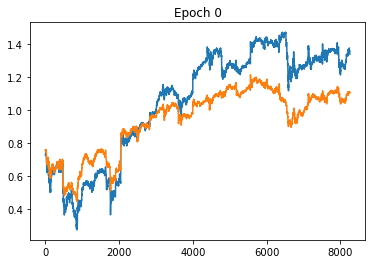

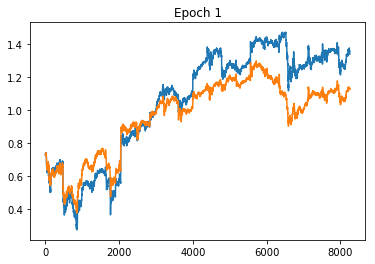

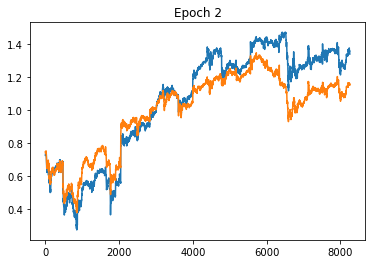

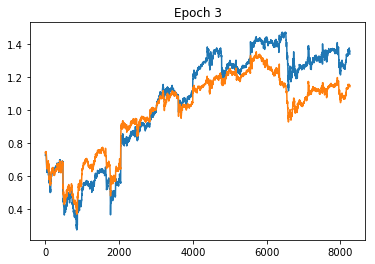

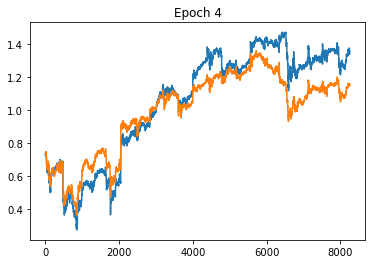

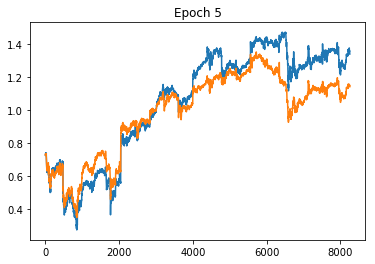

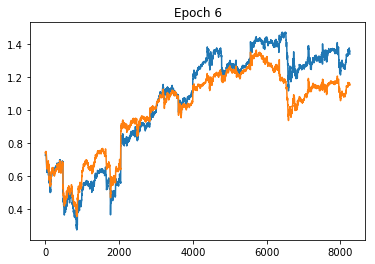

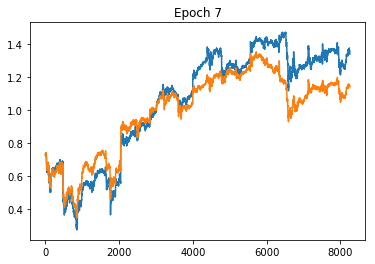

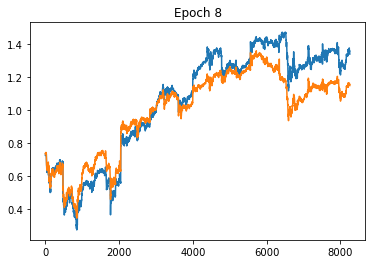

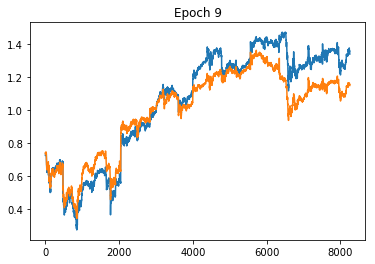

In [62]:
# actual train
num_epochs = 10
batch_size = 1024
loss_train_pca = []
loss_dev_pca = []

with tf.Session() as sess:
    tf.set_random_seed(100)
    sess.run(init)
    
    for e in range(num_epochs):
        
        # Shuffle training data for each epoch
        shuffle_indices = np.random.permutation(np.arange(len(y_train)))
        X_train_e = X_train_pca[shuffle_indices]
        y_train_e = y_train[shuffle_indices]
        
        # Minibatch training
        num_batches = len(y_train) // batch_size
        for iteration in range(num_batches):
            start = iteration * batch_size
            x_batch = X_train_e[start:(start + batch_size)]
            y_batch = y_train_e[start:(start + batch_size)]
            sess.run(train, feed_dict={X: x_batch, y_true: y_batch})
            
        # Monitor training at each epoch
        loss_train_pca.append(sess.run(loss, feed_dict={X: X_train_pca, y_true: y_train}))
        loss_dev_pca.append(sess.run(loss, feed_dict={X: X_dev_pca, y_true: y_dev}))
        print('Loss train: ', loss_train_pca[-1])
        print('Loss test: ', loss_dev_pca[-1])
        # Prediction
        pred = sess.run(output_layer, feed_dict={X: X_dev_pca})

        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        line1, = ax1.plot(y_dev)
        line2, = ax1.plot(y_dev)
        line2.set_ydata(pred)
        plt.title('Epoch ' + str(e))
        plt.pause(0.01)
        
    # report final result
    loss_test_pca = sess.run(loss, feed_dict={X: X_test_pca, y_true: y_test})

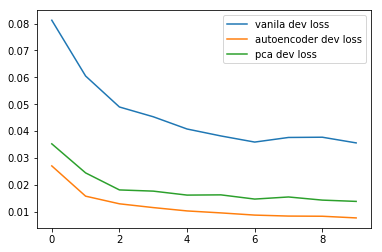

In [63]:
plt.plot(np.arange(num_epochs), loss_dev, label='vanila dev loss')
plt.plot(np.arange(num_epochs), loss_dev_auto, label='autoencoder dev loss')
plt.plot(np.arange(num_epochs), loss_dev_pca, label='pca dev loss')
plt.legend();

In [64]:
print('vanila nn test loss: ', loss_test)
print('pca nn test loss: ', loss_test_pca)
print('autoencoder nn test loss: ', loss_test_auto)

vanila nn test loss:  0.050177425
pca nn test loss:  0.014316286
autoencoder nn test loss:  0.013241208
